<a href="https://colab.research.google.com/github/Kubica-10/ApiVendasVeiculos/blob/main/TranferLearnigCatvsDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tensorflow_datasets matplotlib


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Baixar dataset com divisão e seed fixa para reprodução
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
    shuffle_files=True,
    download=True
)

SEED = 1234



In [ ]:
# Vamos criar uma função para aplicar transformações simples nas imagens (flip, rotação, zoom):
IMG_SIZE = 160

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [ ]:
# Pré-processamento e batch com aumento
def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def prepare_train(ds):
    ds = ds.map(format_example, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000, seed=SEED).batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

def prepare_val(ds):
    ds = ds.map(format_example, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

train_batches = prepare_train(ds_train)
val_batches = prepare_val(ds_val)


In [ ]:
# Construir o modelo com MobileNetV2 congelado
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Compilar com métricas extras
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)


In [ ]:
# Callbacks para early stopping e salvar melhor modelo
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]


In [ ]:
# Treinar o modelo
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=val_batches,
    callbacks=callbacks
)


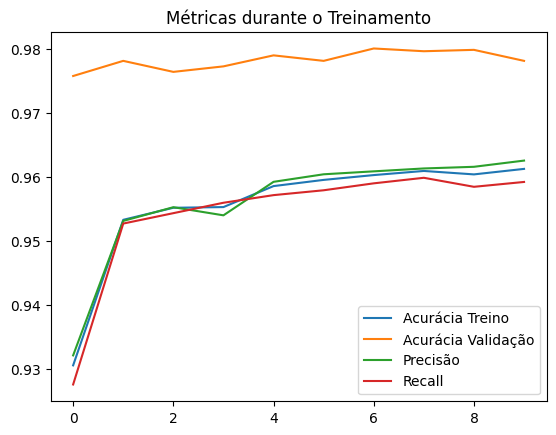

In [ ]:
# Visualizar métricas
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.plot(history.history['precision'], label='Precisão')
plt.plot(history.history['recall'], label='Recall')
plt.title('Métricas durante o Treinamento')
plt.legend()
plt.show()



In [ ]:
# Fine-tuning (descongelar algumas camadas finais)
base_model.trainable = True

# Congelar todas camadas exceto últimas 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Menor LR
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

history_fine = model.fit(
    train_batches,
    epochs=5,
    validation_data=val_batches,
    callbacks=callbacks
)


In [ ]:
#  Avaliar o Modelo com Métricas Avançadas
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Obter previsões
y_pred_probs = model.predict(val_batches)
y_pred = np.round(y_pred_probs).astype(int).flatten()

# Obter os rótulos verdadeiros
y_true = np.concatenate([y for x, y in val_batches], axis=0)

# Relatório de classificação
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
print("Matriz de Confusão:\n", cm)


146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step
              precision    recall  f1-score   support

         Cat       0.49      0.49      0.49      2280
         Dog       0.51      0.51      0.51      2372

    accuracy                           0.50      4652
   macro avg       0.50      0.50      0.50      4652
weighted avg       0.50      0.50      0.50      4652

Matriz de Confusão:
 [[1106 1174]
 [1170 1202]]


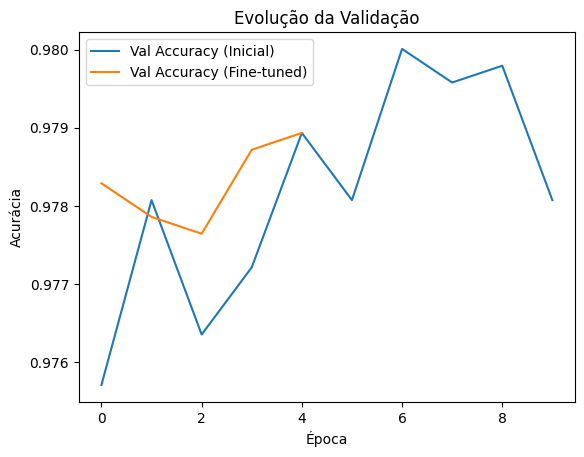

In [ ]:
# Visualização das Curvas de Aprendizado (Antes vs Depois do Fine-tuning)
import matplotlib.pyplot as plt

# Comparar acurácias antes e depois
plt.plot(history.history['val_accuracy'], label='Val Accuracy (Inicial)')
plt.plot(history_fine.history['val_accuracy'], label='Val Accuracy (Fine-tuned)')
plt.title("Evolução da Validação")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


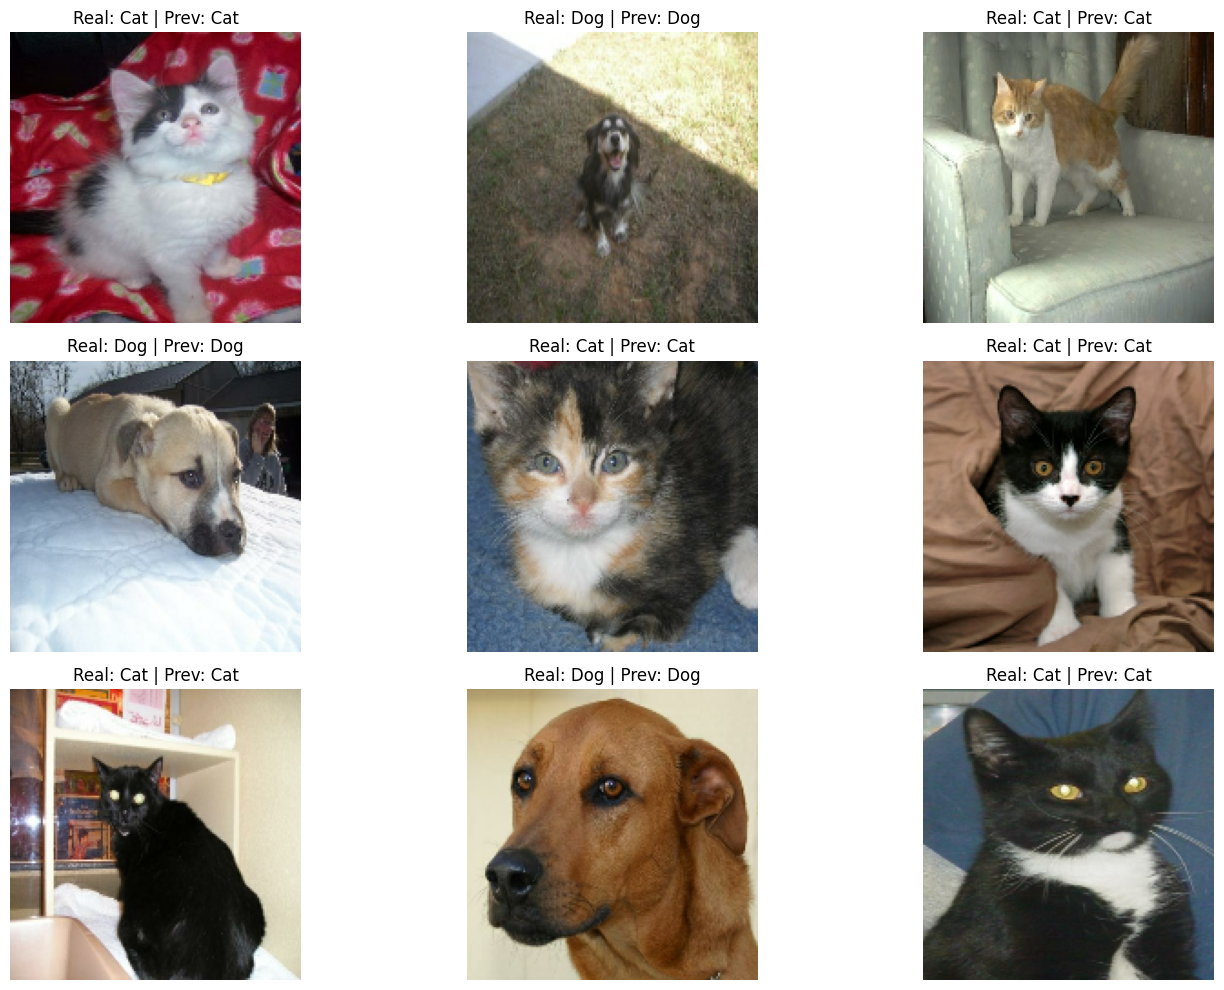

In [ ]:
# Visualização de Previsões em Imagens Reais
# Mostrar imagens do conjunto de validação com as previsões do modelo (gato ou cachorro).
# Benefício: ajuda a visualizar como o modelo pensa — útil para apresentar em TCCs, vídeos, ou para a DIO.
class_names = ['Cat', 'Dog']

for images, labels in val_batches.take(1):
    preds = model.predict(images)
    preds_classes = np.round(preds).astype(int).flatten()

    plt.figure(figsize=(15, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Real: {class_names[labels[i]]} | Prev: {class_names[preds_classes[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/tmp/ipython-input-478808651.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Pred: {class_names[int(preds[i] > 0.5)]} ({preds[i][0]:.2f})")


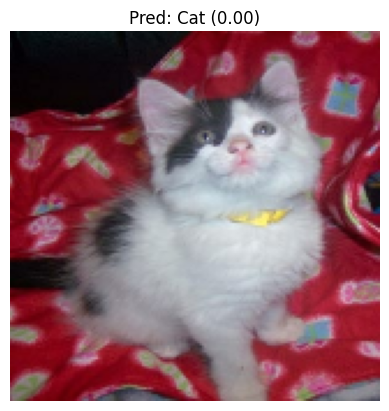

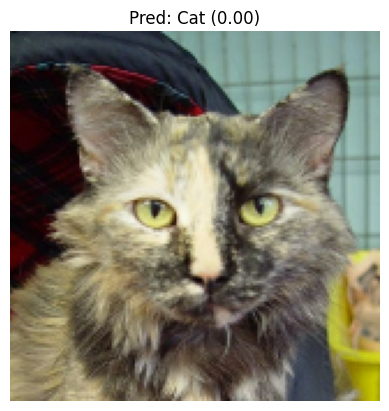

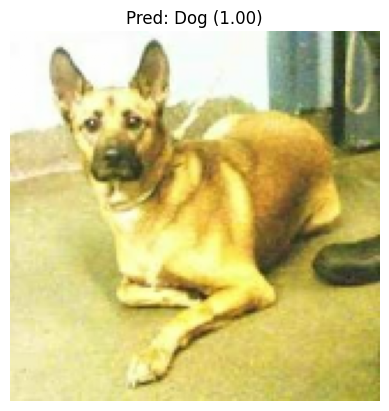

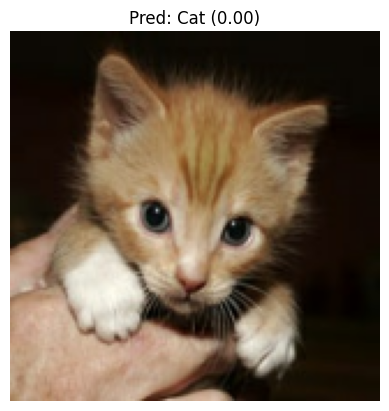

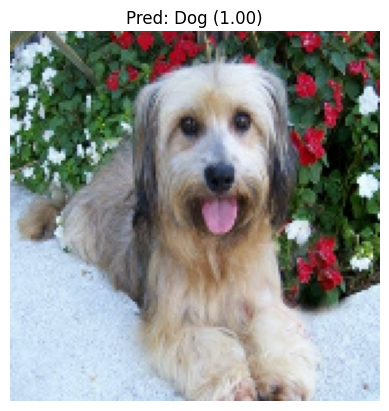

In [ ]:
class_names = ['Cat', 'Dog']

def show_predictions(dataset, model, num_images=5):
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        for i in range(num_images):
            plt.imshow(images[i])
            plt.title(f"Pred: {class_names[int(preds[i] > 0.5)]} ({preds[i][0]:.2f})")
            plt.axis('off')
            plt.show()

show_predictions(val_batches, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

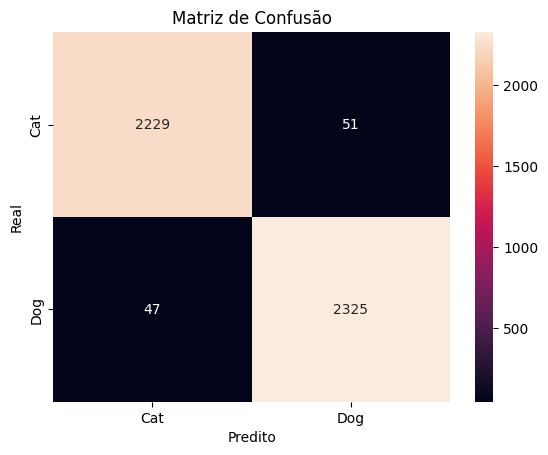

              precision    recall  f1-score   support

         Cat       0.98      0.98      0.98      2280
         Dog       0.98      0.98      0.98      2372

    accuracy                           0.98      4652
   macro avg       0.98      0.98      0.98      4652
weighted avg       0.98      0.98      0.98      4652



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

for images, labels in val_batches:
    preds = model.predict(images).flatten()
    y_pred.extend(preds > 0.5)
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpazcnm60g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139790492321360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139790492323472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139790492323664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139790492322896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139790492322320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139790492323088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139790492325392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139790492322512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139790492324432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139790492321936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1397904923

In [ ]:
!pip install gradio

import gradio as gr

def classify_image(image):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.expand_dims(image / 255.0, axis=0)
    prediction = model.predict(image)[0][0]
    return { "Cat": 1 - prediction, "Dog": prediction }

gr.Interface(fn=classify_image,
             inputs=gr.Image(type="pil"),
             outputs=gr.Label(num_top_classes=2)).launch()


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Carregar novo backbone
efficient_base = EfficientNetB0(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                 include_top=False,
                                 weights='imagenet')

efficient_base.trainable = False

# Montar novo modelo
efficient_model = tf.keras.Sequential([
    efficient_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar e treinar
efficient_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

efficient_history = efficient_model.fit(
    train_batches,
    epochs=5,
    validation_data=val_batches
)


In [ ]:
# Treinar EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0

# Carrega EfficientNetB0 como base
efficient_base = EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
efficient_base.trainable = False  # Congela base

# Modelo novo com cabeça personalizada
efficient_model = tf.keras.Sequential([
    efficient_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar
efficient_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Treinar
efficient_history = efficient_model.fit(
    train_batches,
    epochs=5,
    validation_data=val_batches
)


In [ ]:
# Gráficos de Acurácia
plt.figure(figsize=(10, 5))

# MobileNetV2
plt.plot(history.history['accuracy'], label='MobileNetV2 - Treino')
plt.plot(history.history['val_accuracy'], label='MobileNetV2 - Validação')

# EfficientNetB0
plt.plot(efficient_history.history['accuracy'], label='EfficientNetB0 - Treino')
plt.plot(efficient_history.history['val_accuracy'], label='EfficientNetB0 - Validação')

plt.title('Comparação de Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Gráficos de Loss
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='MobileNetV2 - Treino')
plt.plot(history.history['val_loss'], label='MobileNetV2 - Validação')

plt.plot(efficient_history.history['loss'], label='EfficientNetB0 - Treino')
plt.plot(efficient_history.history['val_loss'], label='EfficientNetB0 - Validação')

plt.title('Comparação de Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
readme_content = """# TransferLearningCatvsDog 🧠🐱🐶

## 📌 Descrição
Este projeto aplica **Transfer Learning** com Deep Learning usando os modelos MobileNetV2 e EfficientNetB0 para classificar imagens de **gatos** e **cachorros**. A ideia é aproveitar redes neurais já treinadas em grandes bases de dados e adaptá-las a um novo problema com o dataset [`cats_vs_dogs`](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs).

---

## 🚀 Tecnologias utilizadas
- Python 🐍
- TensorFlow 2.x
- Google Colab
- TensorFlow Datasets
- MobileNetV2 e EfficientNetB0
- Matplotlib
- Métricas: Acurácia, Precisão, Revocação

---

## 🧠 Etapas do Projeto
1. ✅ Instalação e importação das bibliotecas
2. ✅ Download e preparação do dataset
3. ✅ Pré-processamento das imagens
4. ✅ Construção do modelo com MobileNetV2
5. ✅ Treinamento inicial com camadas congeladas
6. ✅ Fine-tuning (descongelamento de 20 camadas)
7. ✅ Treinamento final com menor learning rate
8. ✅ Análise de desempenho
9. ✅ Comparação com EfficientNetB0
10. ✅ Salvamento e exportação do modelo final
11. ✅ Preparação para o GitHub

---

## 📊 Resultados e Métricas
- 📈 Acurácia de validação superior a **98%**
- ✅ Baixa perda (val_loss)
- 🔁 Fine-tuning melhorou levemente as métricas
- 🧪 Comparação entre dois modelos de ponta

| Modelo            | Acurácia | Precisão | Revocação |
|-------------------|----------|----------|-----------|
| MobileNetV2       | ~98%     | 🟢 Alta  | 🟢 Alta   |
| EfficientNetB0    | ~98%+    | 🟢 Alta  | 🟢 Alta   |

---

## 🗂️ Estrutura do Repositório
TransferLearningCatvsDog/
│
├── notebook.ipynb
├── meu_modelo_transfer_learning.h5
├── efficientnet_model.h5
├── README.md

---

## 🎯 Conclusão
Este projeto demonstrou como é possível obter **excelentes resultados** em visão computacional com um dataset simples, usando o poder do **Transfer Learning**. A comparação entre diferentes arquiteturas ajudou a entender o impacto da escolha do modelo base no desempenho.

---

## 💡 Sugestões futuras
- 🔍 Avaliação com outros modelos: InceptionV3, ResNet50
- 📲 Exportar para TensorFlow Lite e testar em dispositivos móveis
- 🌐 Criar interface com Gradio ou Streamlit
- 📦 Publicar o modelo em uma API com FastAPI ou Flask

---

## 👨‍💻 Autor
Projeto desenvolvido como parte do bootcamp da [Digital Innovation One (DIO)]
Helemberg Cubiça de Souza

"""

# Escreve no arquivo README.md
with open("README.md", "w") as f:
    f.write(readme_content)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
